In [ ]:
import numpy as np
np.random.seed(123)
import keras
keras.__version__

# Introduction to convnets

Let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already been 
through in previous sessions, using a densely-connected network (our test accuracy then was 97.8%). Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from the previous notebook.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via 
passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [ ]:
model.summary()

You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).


Also, notice how the output shape of all convolutional layers is smaller than the input. For instance, `conv2d_1` receives an input of shape `(None,28,28,1)` and returns a volume of shape `(None,26,26,32)`. This is because no padding was added to the input volume before applying the convolution. The output shape of a convolutional layer can be obtained with the following equation:

`W2 = (W - F + 2P)/S + 1`

where `W` is the width of the input, `F` is the kernel size, `P` is the padding and `S` is the stride. We can write a quick function that will compute the output shape for us.

In [ ]:
def conv_output_size(input_size, kernel_size, padding, stride):
    
    return (input_size - kernel_size + 2*padding)/stride + 1

Let's test it for the case of our first convolutional layer. Input size is 28 and kernel size is 3. We have not specified the value for stride (default is 1) or padding (default is 'valid' i.e. no padding):

In [ ]:
conv_output_size(28,3,0,1)

Now let's define our network again, but this time we will apply padding to our inputs.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

`padding = same` applies a padding such that the shape of the input will be preserved in the output. The amount of padding that is needed depends on the size of the kernel: `P = (F-1)/2`. So in our case: P = (3-1)/2 = 1. Keras will compute this value for us automatically. Let's see now how the shape of our outputs has changed:

In [ ]:
model.summary()

And we can use our function again to obtain the output shape of our convolutional layer given the input:

In [ ]:
conv_output_size(28,3,1,1)


The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [ ]:
model.summary()

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Let's now calculate the number of parameters of a convolutional layer. This is given by the following expression:

`F*F*D*C + C`

where `F` is the kernel size, `D` is the dimension of the input and `C` is the number of channels of the convolutional layer. You can see how this resembles the expression that we have previously used for dense layers, except that now we have `FxF` dense layers of dimension `C` that share the same bias.

In [ ]:
def conv2d_params(kernel_size,input_dim,hidden_units):
    
    num_params = kernel_size*kernel_size*hidden_units*input_dim + hidden_units
    
    return num_params

Let's see if our function works in the second layer of our network:

In [ ]:
conv2d_params(3,32,64)

Now let's compute the number of parameters of our network using the functions we created. Let's bring back the one we used to compute the number of parameters of a dense layer:

In [ ]:
def dense_params(input_dims,hidden_units):
    num_params = input_dims*hidden_units + hidden_units
    return num_params

For convenience, let's see the model we just defined in a block-based figure:
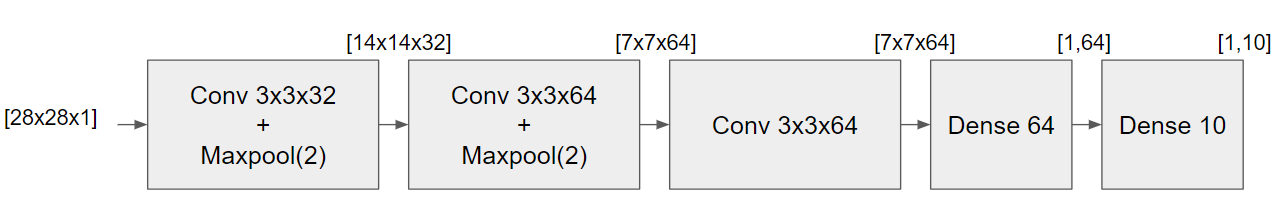

In [ ]:
num_params = 0
conv1=conv2d_params(kernel_size=3, input_dim = 1,hidden_units = 32)
conv2=conv2d_params(kernel_size=3, input_dim = 32,hidden_units = 64)
conv3 =conv2d_params(kernel_size=3, input_dim = 64,hidden_units = 64)

dense1=dense_params(input_dims = 7*7*64, hidden_units = 64)
dense2=dense_params(input_dims = 64, hidden_units = 10)

print ('conv1:',conv1)
print ('conv2',conv2)
print ('conv3:',conv3)
print ('dense1:',dense1)
print ('dense2:',dense2)
print ('total:',conv1+conv2+conv3+dense1+dense2)
model.summary()


Ok, now that we have a good understanding of our model, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from earlier sessions.

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Let's evaluate the model on the test data:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

In [ ]:
test_acc

While our densely-connected network from earlier sessions had a test accuracy of 98%, our basic convnet has a test accuracy of 99%. Not bad! 